# Exploratory Data Analysis Demo 

- Alejandro Hohmann
- Bhanu Muvva
- Chunxia Tong

The purpose of this notebook is to examine the data used in the Staley et al (ST16) model and to recreate their debris flow risk prediction model.

# Table of Contents

### - [EDA](#EDA)

### - [Neural Net](#NN)

In [1]:
%pip install openpyxl==3.1.2

Note: you may need to restart the kernel to use updated packages.


In [2]:
%pip install torch==1.13.1

Note: you may need to restart the kernel to use updated packages.


In [1]:
# assign seed now for consistency any time it needs to be used
seed=27

In [27]:
# file structure libraries
import numpy as np
import pandas as pd
import os

# # visualization libraries
from matplotlib import pyplot as plt
# plt.style.use('bmh')
plt.style.use('dark_background')
# plt.style.use('fivethirtyeight')
# Have plots display in notebook
%matplotlib inline
# import seaborn as sns

# # ML libraries
# from sklearn.preprocessing import StandardScaler
# from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, roc_curve, RocCurveDisplay
# from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import StandardScaler

# # for sigmoid function, in case we need to manually implement in LR
# from scipy.stats import logistic

import torch
import torch.nn as nn
import torch.optim as optim

## The Staley et al. (2016) model report and data 
https://urldefense.com/v3/__https://pubs.er.usgs.gov/publication/ofr20161106__;!!Mih3wA!EBIuZPGKvJZjq-_b5davUFo5Agj8ZiAPbRx8duc_KmRNFY7DlIr6BqoOnEkjMrboYwhKtPyZkN3vH0ZA$ 

## Read in and Examine Staley Raw Data <a id="EDA">

In [5]:
xl=pd.ExcelFile("../data/ofr20161106_appx-1.xlsx")
desc=xl.parse(xl.sheet_names[0])
raw_data=xl.parse(xl.sheet_names[1])

In [6]:
# # can be helpful for reference
# data_dict = pd.read_excel(file, sheet_name=sheets[0])

# dict_cols = data_dict.columns

# data_dict.sort_values(by=dict_cols[0])

In [7]:
raw_data

,Fire Name,Year,Fire_ID,Fire_SegID,Database,State,UTM_Zone,UTM_X,UTM_Y,Response,...,Peak_I15_mm/h,Peak_I30_mm/h,Peak_I60_mm/h,ContributingArea_km2,PropHM23,dNBR/1000,KF,Acc015_mm,Acc030_mm,Acc060_mm
0,Buckweed,2007,bck,bck_1035,Training,CA,11,368133.5165,3823231.989,0,...,3.2,2.0,2.0,0.378767,0.217933,0.297853,0.250000,0.80,1.0,2.0
1,Buckweed,2007,bck,bck_1090,Training,CA,11,367871.0165,3822984.489,0,...,3.2,2.0,2.0,0.689615,0.061249,0.224896,0.250000,0.80,1.0,2.0
2,Buckweed,2007,bck,bck_1570,Training,CA,11,367503.5165,3821741.989,0,...,3.2,2.0,2.0,2.757312,0.042968,0.065537,0.248541,0.80,1.0,2.0
3,Buckweed,2007,bck,bck_235,Training,CA,11,371108.5165,3824991.989,0,...,1.6,1.2,0.8,0.613415,0.092164,0.141711,0.250000,0.40,0.6,0.8
4,Buckweed,2007,bck,bck_363,Training,CA,11,370763.5165,3824576.989,0,...,1.6,1.2,0.8,0.538875,0.058353,0.210158,0.250000,0.40,0.6,0.8
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1545,Wallow,2011,wlw,wlw_47409,Test,AZ,12,660698.3581,3725248.835,0,...,14.0,8.0,NaN,1.554356,0.009801,0.187053,0.000000,3.50,4.0,NaN
1546,Wallow,2011,wlw,wlw_47535,Test,AZ,12,660178.3581,3725128.835,0,...,63.0,54.0,39.0,0.683425,0.001571,0.500223,0.000000,15.75,27.0,39.0
1547,Wallow,2011,wlw,wlw_47535,Test,AZ,12,660178.3581,3725128.835,0,...,29.0,16.0,NaN,0.683425,0.001571,0.500223,0.000000,7.25,8.0,NaN
1548,Wallow,2011,wlw,wlw_47535,Test,AZ,12,660178.3581,3725128.835,0,...,25.0,16.0,NaN,0.683425,0.001571,0.500223,0.000000,6.25,8.0,NaN


In [8]:
raw_data['State'].value_counts()

State
CA    939
CO    300
AZ    209
NM     58
MT     26
ID     14
UT      4
Name: count, dtype: int64

In [9]:
raw_data['Database'].value_counts()

Database
Training    939
Test        611
Name: count, dtype: int64

In [10]:
raw_data.shape

(1550, 27)

In [11]:
# raw_data.describe().T

## Handling Missing Values

### Determine features with missing values

In [12]:
print("NAs for each feature:")
raw_data.isna().sum()

NAs for each feature:


Fire Name                 0
Year                      0
Fire_ID                   0
Fire_SegID                0
Database                  0
State                     0
UTM_Zone                  0
UTM_X                     0
UTM_Y                     0
Response                  0
StormDate                 0
GaugeDist_m               0
StormStart              160
StormEnd                160
StormDur_H                0
StormAccum_mm             0
StormAvgI_mm/h            0
Peak_I15_mm/h           230
Peak_I30_mm/h           214
Peak_I60_mm/h           256
ContributingArea_km2      0
PropHM23                  0
dNBR/1000                77
KF                        0
Acc015_mm               230
Acc030_mm               214
Acc060_mm               256
dtype: int64

In [13]:
# Features without missing values
list(raw_data.columns[raw_data.isna().sum() == 0])

['Fire Name',
 'Year',
 'Fire_ID',
 'Fire_SegID',
 'Database',
 'State',
 'UTM_Zone',
 'UTM_X',
 'UTM_Y',
 'Response',
 'StormDate',
 'GaugeDist_m',
 'StormDur_H',
 'StormAccum_mm',
 'StormAvgI_mm/h',
 'ContributingArea_km2',
 'PropHM23',
 'KF']

### Remove rows with missing values

In [14]:
print("Dimensions before removing null values:\n ", raw_data.shape)

raw_data.dropna(inplace=True)   # NOTE: Original raw_data is overwritten
print("Dimensions after removing null values: \n ", raw_data.shape)

Dimensions before removing null values:
  (1550, 27)
Dimensions after removing null values: 
  (1091, 27)


In [15]:
# raw_data.describe().round(2).T

### Save data without missing values to new file

In [16]:
# Save  data in csv file format, not including index as a column
raw_data.to_csv("ofr20161106-na-omit.csv", index=False)

## Explore by Data Types
- aggregate peak rainfall feature to three different time amounts
    - 15 min
    - 30 min
    - 60 min

In [17]:
raw_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1091 entries, 0 to 1546
Data columns (total 27 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   Fire Name             1091 non-null   object        
 1   Year                  1091 non-null   int64         
 2   Fire_ID               1091 non-null   object        
 3   Fire_SegID            1091 non-null   object        
 4   Database              1091 non-null   object        
 5   State                 1091 non-null   object        
 6   UTM_Zone              1091 non-null   int64         
 7   UTM_X                 1091 non-null   float64       
 8   UTM_Y                 1091 non-null   float64       
 9   Response              1091 non-null   int64         
 10  StormDate             1091 non-null   object        
 11  GaugeDist_m           1091 non-null   float64       
 12  StormStart            1091 non-null   datetime64[ns]
 13  StormEnd              1

In [18]:
# raw_data

In [19]:
# select the feature and result columns
raw_data_feat_15 = raw_data[['Peak_I15_mm/h','PropHM23','dNBR/1000','KF','Response']]

# save to a new csv file with Peak_I15_mm/h
raw_data_feat_15.to_csv('ofr20161106-na-omit-feat-15.csv', index=False)

In [20]:
raw_data_feat_15

,Peak_I15_mm/h,PropHM23,dNBR/1000,KF,Response
0,3.2,0.217933,0.297853,0.250000,0
1,3.2,0.061249,0.224896,0.250000,0
2,3.2,0.042968,0.065537,0.248541,0
3,1.6,0.092164,0.141711,0.250000,0
4,1.6,0.058353,0.210158,0.250000,0
...,...,...,...,...,...
1530,63.0,0.066777,0.373291,0.000000,0
1534,63.0,0.115890,0.604177,0.000000,0
1538,63.0,0.112607,0.428204,0.000000,1
1542,63.0,0.009801,0.187053,0.000000,1


In [21]:
# select the feature and result columns
raw_data_feat_30 = raw_data[['Peak_I30_mm/h','PropHM23','dNBR/1000','KF','Response']]

# save to a new csv file with Peak_I30_mm/h
raw_data_feat_30.to_csv('ofr20161106-na-omit-feat-30.csv', index=False)

In [22]:
raw_data_feat_30

,Peak_I30_mm/h,PropHM23,dNBR/1000,KF,Response
0,2.0,0.217933,0.297853,0.250000,0
1,2.0,0.061249,0.224896,0.250000,0
2,2.0,0.042968,0.065537,0.248541,0
3,1.2,0.092164,0.141711,0.250000,0
4,1.2,0.058353,0.210158,0.250000,0
...,...,...,...,...,...
1530,54.0,0.066777,0.373291,0.000000,0
1534,54.0,0.115890,0.604177,0.000000,0
1538,54.0,0.112607,0.428204,0.000000,1
1542,54.0,0.009801,0.187053,0.000000,1


In [23]:
# select the feature and result columns
raw_data_feat_60 = raw_data[['Peak_I60_mm/h','PropHM23','dNBR/1000','KF','Response']]

# save to a new csv file with Peak_I60_mm/h
raw_data_feat_60.to_csv('ofr20161106-na-omit-feat-60.csv', index=False)

In [24]:
raw_data_feat_60

,Peak_I60_mm/h,PropHM23,dNBR/1000,KF,Response
0,2.0,0.217933,0.297853,0.250000,0
1,2.0,0.061249,0.224896,0.250000,0
2,2.0,0.042968,0.065537,0.248541,0
3,0.8,0.092164,0.141711,0.250000,0
4,0.8,0.058353,0.210158,0.250000,0
...,...,...,...,...,...
1530,39.0,0.066777,0.373291,0.000000,0
1534,39.0,0.115890,0.604177,0.000000,0
1538,39.0,0.112607,0.428204,0.000000,1
1542,39.0,0.009801,0.187053,0.000000,1


In [3]:
import geopandas as gpd
df = modelDataI=gpd.read_parquet("../data/staley16_observations_catchment_fuelpars_rocktype_randn_v3.parquet")
print('raw data -',df.shape)

df=df.dropna()
print('after nulls removed -',df.shape)

#store clean data to file, this will be used as input to model
df.to_csv("ST16-observations-new-features-v3-na-omit.csv", index=False)

raw data - (1550, 44)
after nulls removed - (1089, 44)


In [29]:
# try with one peak* feature and acc* feature 
features = ['peak_i15_mmh','peak_i30_mmh', 'peak_i60_mmh', 'contributingarea_km2', 'prophm23',
           'dnbr1000', 'kf', 'acc015_mm', 'acc030_mm', 'acc060_mm', 'NB', 'GR', 'GS', 'SH', 'TU', 'TL', 'dom',
           'Fine fuel load', 'SAV', 'Packing ratio', 'Extinction moisture content',
           'Igneous', 'Metamorphic', 'Sedimentary', 'Unconsolidated', 'domrt']

features_15 = ['peak_i15_mmh', 'contributingarea_km2', 'prophm23',
               'dnbr1000', 'kf', 'acc015_mm', 'NB', 'GR', 'GS', 'SH', 'TU', 'TL',
               'Fine fuel load', 'SAV', 'Packing ratio', 'Extinction moisture content',
               'Igneous', 'Metamorphic', 'Sedimentary', 'Unconsolidated',
#                'dom','domrt'
              ]

features_30 = [
       'peak_i30_mmh', 'contributingarea_km2', 'prophm23',
       'dnbr1000', 'kf','acc030_mm', 'NB', 'GR', 'GS', 'SH', 'TU', 'TL', 'dom',
       'Fine fuel load', 'SAV', 'Packing ratio', 'Extinction moisture content',
        'Igneous', 'Metamorphic', 'Sedimentary', 'Unconsolidated', 'domrt']

features_60= ['peak_i60_mmh', 'contributingarea_km2', 'prophm23',
       'dnbr1000', 'kf','acc060_mm', 'NB', 'GR', 'GS', 'SH', 'TU', 'TL', 'dom',
       'Fine fuel load', 'SAV', 'Packing ratio', 'Extinction moisture content',
        'Igneous', 'Metamorphic', 'Sedimentary', 'Unconsolidated', 'domrt']


y= df['response']

In [45]:
X = data[features_15]
y=data['response']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=seed)

type(X_train)   

pandas.core.frame.DataFrame

## Neural Net <a id="NN">

In [9]:
class Net(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, dropout_rate):
        super(Net, self).__init__()
        
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.relu1 = nn.ReLU()
        self.dropout1 = nn.Dropout(dropout_rate) # dropout to prevent overfitting
        
        self.fc2 = nn.Linear(hidden_size, hidden_size)
        self.relu2 = nn.ReLU()
        self.dropout2 = nn.Dropout(dropout_rate) # dropout to prevent overfitting
        
        self.fc3 = nn.Linear(hidden_size, hidden_size)
        self.relu3 = nn.ReLU()
        self.dropout3 = nn.Dropout(dropout_rate) # dropout to prevent overfitting

        self.fc4 = nn.Linear(hidden_size, hidden_size)
        self.relu4 = nn.ReLU()
        self.dropout4 = nn.Dropout(dropout_rate) # dropout to prevent overfitting
        
        self.fc5 = nn.Linear(hidden_size, output_size)
        self.sigmoid = nn.Sigmoid() # output to probability rather than bool
        
        
    def forward(self, x):
        out = self.fc1(x)
        out = self.relu1(out)
        out = self.dropout1(out)
        
        out = self.fc2(out)
        out = self.relu2(out)
        out = self.dropout2(out)
        
        out = self.fc3(out)
        out = self.relu3(out)
        out = self.dropout3(out)
        
        out = self.fc4(out)
        out = self.relu4(out)
        out = self.dropout4(out)
        
        out = self.fc5(out)
        out = self.sigmoid(out)      

        return out

In [10]:
# # can't really compare loss between different loss-functions

Training loss: 0.11860574036836624
Validation loss: 0.6358736157417297


Training accuracy: 0.9460390355912744
Test accuracy: 0.8348623853211009


F1 Score (test): 0.6896551724137931


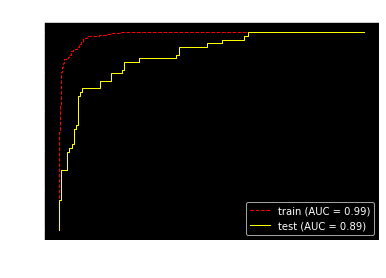

In [48]:
# 15 MIN
if __name__ == '__main__':
    # Load data
    data = pd.read_csv('ST16-observations-new-features-v3-na-omit.csv')
    
    X = data[features_15]
    y=data['response']
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=seed)
    
    #scale the data X_train and X_test
    cols = X_train.columns
    sc = StandardScaler()
    X_train = pd.DataFrame(sc.fit_transform(X_train), columns=cols)
    X_test = pd.DataFrame(sc.transform(X_test), columns=cols)
    
    X_train = torch.tensor(X_train.values).float()
    y_train = torch.tensor(y_train.values).float().view(-1, 1)
    X_test = torch.tensor(X_test.values).float()
    y_test = torch.tensor(y_test.values).float().view(-1, 1)
     
    input_size = X_train.shape[1]
    hidden_size = 500
    output_size = 1
    dropout_rate = 0.2
    learning_rate = 0.001 # 0.001 is default value for Adam optimizer
    
    model = Net(input_size, hidden_size, output_size, dropout_rate)
    
    # criterion = nn.MSELoss() 
    criterion = nn.BCELoss()  # cross-entropy better suited for binary classification than MSE
    #criterion = nn.BCEWithLogitsLoss(pos_weight=torch.ones([output_size]))
    #criterion = nn.NLLLoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
      
    num_epochs = 100
    
    for epoch in range(num_epochs):
        y_train_pred = model(X_train)
        loss = criterion(y_train_pred, y_train)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
torch.save(model.state_dict(), 'model.pth')    
y_train_pred = model(X_train)
#y_train_prob = torch.sigmoid(y_train_pred) # already a probability

y_test_pred = model(X_test)
# y_test_prob = torch.sigmoid(y_test_pred) # already a probability

train_loss = criterion(y_train_pred, y_train)
val_loss = criterion(y_test_pred, y_test)

print(f'Training loss: {train_loss}')
print(f'Validation loss: {val_loss}')

print("\n")

# accuracy
train_pred_correct = sum(y_train.detach().numpy() == np.round(y_train_pred.detach().numpy()))
train_accuracy = (train_pred_correct / y_train.shape[0])[0]
print(f'Training accuracy: {train_accuracy}')

test_pred_correct = sum(y_test.detach().numpy() == np.round(y_test_pred.detach().numpy()))
test_accuracy = (test_pred_correct / y_test.shape[0])[0]
print(f'Test accuracy: {test_accuracy}')

# f1
f1_output = f1_score(y_test, np.round(y_test_pred.detach().numpy()))
print("\n")
print(f'F1 Score (test): {f1_output}')
# plot AUC
fig, ax = plt.subplots()

RocCurveDisplay.from_predictions(y_train.detach().numpy(), 
                                 y_train_pred.detach().numpy(), 
                                 ax=ax, 
                                 linewidth=1, 
                                 color='red', 
                                 name='train', 
                                 linestyle="dashed"
                                );

RocCurveDisplay.from_predictions(y_test.detach().numpy(), 
                                 y_test_pred.detach().numpy(),
                                 ax=ax, 
                                 linewidth=1, 
                                 color='yellow', 
                                 name='test');

plt.title('FC NN w/ BCELoss: 15 min rain accum.');

# without new features

# Training loss: 0.4574218988418579
# Validation loss: 0.4336346983909607


# Training accuracy: 0.7580275229357798
# Test accuracy: 0.7442922374429224


# F1 Score (test): 0.24324324324324326

Training loss: 0.4434523284435272
Validation loss: 0.4113563299179077


Training accuracy: 0.7534403669724771
Test accuracy: 0.776255707762557


F1 Score (test): 0.4842105263157895


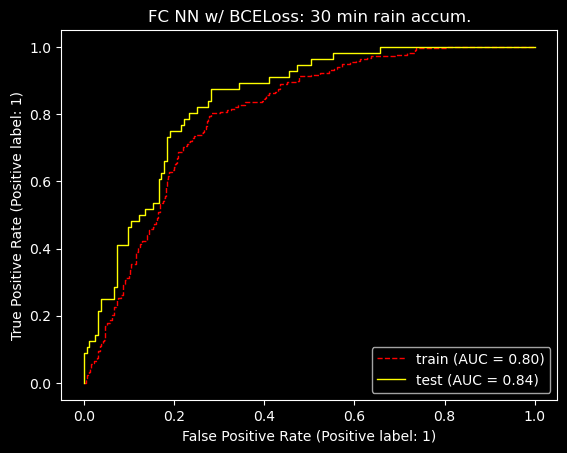

In [30]:
# 30 MIN
if __name__ == '__main__':
    # Load data
    data = pd.read_csv('ofr20161106-na-omit-feat-30.csv')
    X = data.iloc[:, :4] # input features
    y = data.iloc[:, 4] # debris flow bool
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=seed)
    X_train = torch.tensor(X_train.values).float()
    y_train = torch.tensor(y_train.values).float().view(-1, 1)
    X_test = torch.tensor(X_test.values).float()
    y_test = torch.tensor(y_test.values).float().view(-1, 1)
     
    input_size = X_train.shape[1]
    hidden_size = 500
    output_size = 1
    dropout_rate = 0.2  
    learning_rate = 0.001 # 0.001 is default value for Adam optimizer
    
    model = Net(input_size, hidden_size, output_size, dropout_rate)
    
    # criterion = nn.MSELoss() 
    criterion = nn.BCELoss()  # cross-entropy better suited for binary classification than MSE
    #criterion = nn.BCEWithLogitsLoss(pos_weight=torch.ones([output_size]))
    #criterion = nn.NLLLoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
      
    num_epochs = 100
    
    for epoch in range(num_epochs):
        y_train_pred = model(X_train)
        loss = criterion(y_train_pred, y_train)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    
torch.save(model.state_dict(), 'model.pth')    
y_train_pred = model(X_train)
y_train_prob = torch.sigmoid(y_train_pred)

y_test_pred = model(X_test)
y_test_prob = torch.sigmoid(y_test_pred)

train_loss = criterion(y_train_pred, y_train)
val_loss = criterion(y_test_pred, y_test)

print(f'Training loss: {train_loss}')
print(f'Validation loss: {val_loss}')

print("\n")

# accuracy
train_pred_correct = sum(y_train.detach().numpy() == np.round(y_train_pred.detach().numpy()))
train_accuracy = (train_pred_correct / y_train.shape[0])[0]
print(f'Training accuracy: {train_accuracy}')

test_pred_correct = sum(y_test.detach().numpy() == np.round(y_test_pred.detach().numpy()))
test_accuracy = (test_pred_correct / y_test.shape[0])[0]
print(f'Test accuracy: {test_accuracy}')

# f1
f1_output = f1_score(y_test, np.round(y_test_pred.detach().numpy()))
print("\n")
print(f'F1 Score (test): {f1_output}')
# plot AUC
fig, ax = plt.subplots()

RocCurveDisplay.from_predictions(y_train.detach().numpy(), 
                                 y_train_pred.detach().numpy(), 
                                 ax=ax, 
                                 linewidth=1, 
                                 color='red', 
                                 name='train', 
                                 linestyle="dashed"
                                );

RocCurveDisplay.from_predictions(y_test.detach().numpy(), 
                                 y_test_pred.detach().numpy(), 
                                 ax=ax, 
                                 linewidth=1, 
                                 color='yellow', 
                                 name='test');

plt.title('FC NN w/ BCELoss: 30 min rain accum.');

Training loss: 0.44735732674598694
Validation loss: 0.40253081917762756


Training accuracy: 0.7878440366972477
Test accuracy: 0.7853881278538812


F1 Score (test): 0.584070796460177


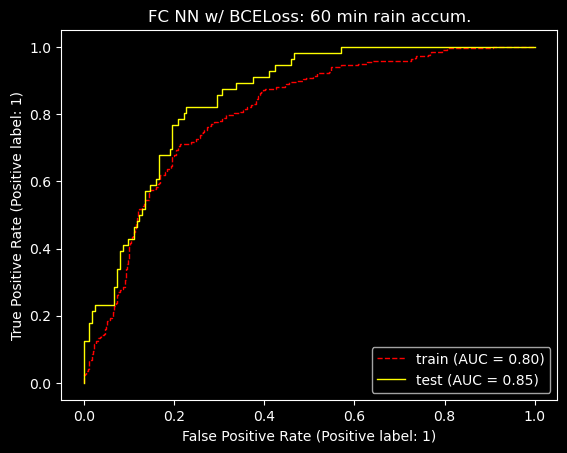

In [31]:
# 60 MIN
if __name__ == '__main__':
    # Load data
    data = pd.read_csv('ofr20161106-na-omit-feat-60.csv')
    X = data.iloc[:, :4] # input features
    y = data.iloc[:, 4] # debris flow bool
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=seed)
    X_train = torch.tensor(X_train.values).float()
    y_train = torch.tensor(y_train.values).float().view(-1, 1)
    X_test = torch.tensor(X_test.values).float()
    y_test = torch.tensor(y_test.values).float().view(-1, 1)
     
    input_size = X_train.shape[1]
    hidden_size = 500
    output_size = 1
    dropout_rate = 0.2  
    learning_rate = 0.001 # 0.001 is default value for Adam optimizer
    
    model = Net(input_size, hidden_size, output_size, dropout_rate)
    
    # criterion = nn.MSELoss() 
    criterion = nn.BCELoss()  # cross-entropy better suited for binary classification than MSE
    #criterion = nn.BCEWithLogitsLoss(pos_weight=torch.ones([output_size]))
    #criterion = nn.NLLLoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
      
    num_epochs = 100
    
    for epoch in range(num_epochs):
        y_train_pred = model(X_train)
        loss = criterion(y_train_pred, y_train)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()   
    
torch.save(model.state_dict(), 'model.pth')    
y_train_pred = model(X_train)
y_train_prob = torch.sigmoid(y_train_pred)

y_test_pred = model(X_test)
y_test_prob = torch.sigmoid(y_test_pred)

train_loss = criterion(y_train_pred, y_train)
val_loss = criterion(y_test_pred, y_test)

print(f'Training loss: {train_loss}')
print(f'Validation loss: {val_loss}')

print("\n")

# accuracy
train_pred_correct = sum(y_train.detach().numpy() == np.round(y_train_pred.detach().numpy()))
train_accuracy = (train_pred_correct / y_train.shape[0])[0]
print(f'Training accuracy: {train_accuracy}')

test_pred_correct = sum(y_test.detach().numpy() == np.round(y_test_pred.detach().numpy()))
test_accuracy = (test_pred_correct / y_test.shape[0])[0]
print(f'Test accuracy: {test_accuracy}')

# f1
f1_output = f1_score(y_test, np.round(y_test_pred.detach().numpy()))
print("\n")
print(f'F1 Score (test): {f1_output}')

# plot AUC
fig, ax = plt.subplots()

RocCurveDisplay.from_predictions(y_train.detach().numpy(), 
                                 y_train_pred.detach().numpy(), 
                                 ax=ax, 
                                 linewidth=1, 
                                 color='red', 
                                 name='train', 
                                 linestyle="dashed"
                                );

RocCurveDisplay.from_predictions(y_test.detach().numpy(), 
                                 y_test_pred.detach().numpy(), 
                                 ax=ax, 
                                 linewidth=1, 
                                 color='yellow', 
                                 name='test');

plt.title('FC NN w/ BCELoss: 60 min rain accum.');

Training loss: 0.366464763879776
Validation loss: 0.3664504587650299


Training accuracy: 0.7970183486238532
Test accuracy: 0.8127853881278538


F1 Score (test): 0.6019417475728156


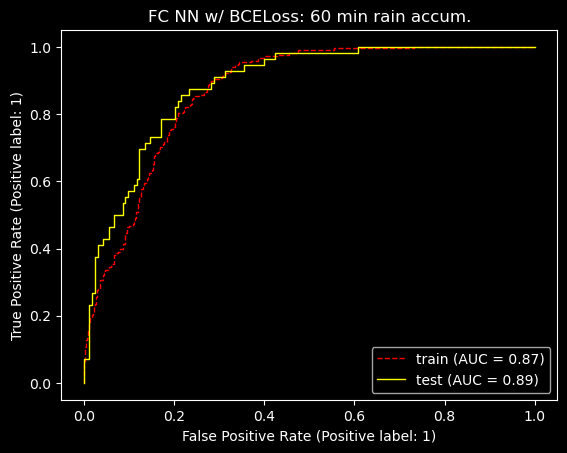

In [32]:
# 60 MIN
if __name__ == '__main__':
    # Load data
    data = pd.read_csv('ofr20161106-na-omit-feat-60.csv')
    X = data.iloc[:, :4] # input features
    y = data.iloc[:, 4] # debris flow bool
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=seed)
    X_train = torch.tensor(X_train.values).float()
    y_train = torch.tensor(y_train.values).float().view(-1, 1)
    X_test = torch.tensor(X_test.values).float()
    y_test = torch.tensor(y_test.values).float().view(-1, 1)
     
    input_size = X_train.shape[1]
    hidden_size = 500
    output_size = 1
    dropout_rate = 0.2  
    learning_rate = 0.001 # 0.001 is default value for Adam optimizer
    
    model = Net(input_size, hidden_size, output_size, dropout_rate)
    
    # criterion = nn.MSELoss() 
    criterion = nn.BCELoss()  # cross-entropy better suited for binary classification than MSE
    #criterion = nn.BCEWithLogitsLoss(pos_weight=torch.ones([output_size]))
    #criterion = nn.NLLLoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
      
    num_epochs = 1000
    
    for epoch in range(num_epochs):
        y_train_pred = model(X_train)
        loss = criterion(y_train_pred, y_train)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()   
    
torch.save(model.state_dict(), 'model.pth')    
y_train_pred = model(X_train)
y_train_prob = torch.sigmoid(y_train_pred)

y_test_pred = model(X_test)
y_test_prob = torch.sigmoid(y_test_pred)

train_loss = criterion(y_train_pred, y_train)
val_loss = criterion(y_test_pred, y_test)

print(f'Training loss: {train_loss}')
print(f'Validation loss: {val_loss}')

print("\n")

# accuracy
train_pred_correct = sum(y_train.detach().numpy() == np.round(y_train_pred.detach().numpy()))
train_accuracy = (train_pred_correct / y_train.shape[0])[0]
print(f'Training accuracy: {train_accuracy}')

test_pred_correct = sum(y_test.detach().numpy() == np.round(y_test_pred.detach().numpy()))
test_accuracy = (test_pred_correct / y_test.shape[0])[0]
print(f'Test accuracy: {test_accuracy}')

# f1
f1_output = f1_score(y_test, np.round(y_test_pred.detach().numpy()))
print("\n")
print(f'F1 Score (test): {f1_output}')

# plot AUC
fig, ax = plt.subplots()

RocCurveDisplay.from_predictions(y_train.detach().numpy(), 
                                 y_train_pred.detach().numpy(), 
                                 ax=ax, 
                                 linewidth=1, 
                                 color='red', 
                                 name='train', 
                                 linestyle="dashed"
                                );

RocCurveDisplay.from_predictions(y_test.detach().numpy(), 
                                 y_test_pred.detach().numpy(), 
                                 ax=ax, 
                                 linewidth=1, 
                                 color='yellow', 
                                 name='test');

plt.title('FC NN w/ BCELoss: 60 min rain accum.');

## Use Staley cross product features
- swapped out 15 min rain accumulation for 60 min rain accumulation

In [33]:
staley_data = raw_data.copy()

#computing input data similar to Staley'16
staley_data["PropHM23_x_i60"] = staley_data["PropHM23"] * staley_data["Acc060_mm"]
staley_data["dNBR_x_i60"] = staley_data["dNBR/1000"] * staley_data["Acc060_mm"]
staley_data["KF_x_i60"] = staley_data["KF"] * staley_data["Acc060_mm"]

use_cols=["PropHM23_x_i60",
          "dNBR_x_i60", 
          "KF_x_i60",
          "Response",
         ]
staley_data = staley_data[use_cols]
staley_data

,PropHM23_x_i60,dNBR_x_i60,KF_x_i60,Response
0,0.435865,0.595706,0.500000,0
1,0.122497,0.449791,0.500000,0
2,0.085936,0.131075,0.497081,0
3,0.073732,0.113369,0.200000,0
4,0.046682,0.168126,0.200000,0
...,...,...,...,...
1530,2.604307,14.558344,0.000000,0
1534,4.519721,23.562891,0.000000,0
1538,4.391669,16.699955,0.000000,1
1542,0.382221,7.295049,0.000000,1


Training loss: 0.19206199049949646
Validation loss: 0.8025881052017212


Training accuracy: 0.908256880733945
Test accuracy: 0.7625570776255708


F1 Score (test): 0.5438596491228069


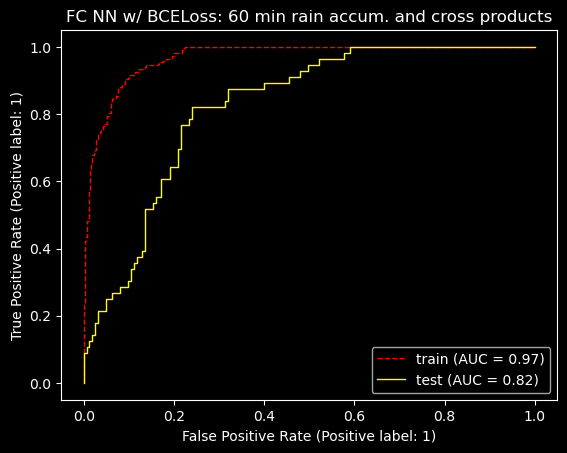

In [39]:
# 60 MIN
if __name__ == '__main__':
    # Load data
    data = staley_data.copy()
    X = data.iloc[:, :3] # input features
    y = data.iloc[:, 3] # debris flow bool
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=seed)
    X_train = torch.tensor(X_train.values).float()
    y_train = torch.tensor(y_train.values).float().view(-1, 1)
    X_test = torch.tensor(X_test.values).float()
    y_test = torch.tensor(y_test.values).float().view(-1, 1)
     
    input_size = X_train.shape[1]
    hidden_size = 500
    output_size = 1
    dropout_rate = 0.2  
    learning_rate = 0.001 # 0.001 is default value for Adam optimizer
    
    model = Net(input_size, hidden_size, output_size, dropout_rate)
    
    # criterion = nn.MSELoss() 
    criterion = nn.BCELoss()  # cross-entropy better suited for binary classification than MSE
    #criterion = nn.BCEWithLogitsLoss(pos_weight=torch.ones([output_size]))
    #criterion = nn.NLLLoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
      
    num_epochs = 1000
    
    for epoch in range(num_epochs):
        y_train_pred = model(X_train)
        loss = criterion(y_train_pred, y_train)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()   
    
torch.save(model.state_dict(), 'model.pth')    
y_train_pred = model(X_train)
y_train_prob = torch.sigmoid(y_train_pred)

y_test_pred = model(X_test)
y_test_prob = torch.sigmoid(y_test_pred)

train_loss = criterion(y_train_pred, y_train)
val_loss = criterion(y_test_pred, y_test)

print(f'Training loss: {train_loss}')
print(f'Validation loss: {val_loss}')

print("\n")

# accuracy
train_pred_correct = sum(y_train.detach().numpy() == np.round(y_train_pred.detach().numpy()))
train_accuracy = (train_pred_correct / y_train.shape[0])[0]
print(f'Training accuracy: {train_accuracy}')

test_pred_correct = sum(y_test.detach().numpy() == np.round(y_test_pred.detach().numpy()))
test_accuracy = (test_pred_correct / y_test.shape[0])[0]
print(f'Test accuracy: {test_accuracy}')

# f1
f1_output = f1_score(y_test, np.round(y_test_pred.detach().numpy()))
print("\n")
print(f'F1 Score (test): {f1_output}')

# plot AUC
fig, ax = plt.subplots()

RocCurveDisplay.from_predictions(y_train.detach().numpy(), 
                                 y_train_pred.detach().numpy(), 
                                 ax=ax, 
                                 linewidth=1, 
                                 color='red', 
                                 name='train', 
                                 linestyle="dashed"
                                );

RocCurveDisplay.from_predictions(y_test.detach().numpy(), 
                                 y_test_pred.detach().numpy(), 
                                 ax=ax, 
                                 linewidth=1, 
                                 color='yellow', 
                                 name='test');

plt.title('FC NN w/ BCELoss: 60 min rain accum. and crossproduct features');